## Traffic State Estimator (TSE) Training

__1. Training Data:__

    - Data collection: Ring (all 22 vehicles inluding RL are kept as IDM)
    - The data is collected at initial configuration of vehicles equally spaced, for for a brief time there will be stable conditions.
    - 400 simulation runs are performed each with a warmup time of 2500 and horizon of 0. This was based on the observation that test accuracy gets better with more data.
    
__2. Neural Network configuration:__

    - Keeping in mind that this same neural network is to be scaled to numerous densities
    - Activation
    
__3. Data Processing:__

    - The collected data mostly contains non-transition data.
    - It is filtered and made equally representative of transition and non-transition (50% each).
    - Further, the data is also made equally representative of the 5 (out of  6) class labels.
    - Perhaps, as additional safety the sixth one (with no car in front has also to be added in the future)
    
__Additional Notes:__

    - Essentially, the TSE predicts if the RL vehicle were IDM, then what would be the expected traffic state 10-timesteps into the future.

In [1]:
import os
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Load data into one single structure

#works with multiple npy files, stacks the data read from each file
files = os.listdir('./tse_data')
npy_files = [file for file in files if file.endswith('.npy')]
print(f"Total {len(npy_files)} files", end = "\n\n")

all_data = []
for file in npy_files:
    data = np.load('./tse_data/'+ file, allow_pickle=True)
    #print(f"{data.shape}\t{data[:, 0].shape}\t{data[:, 1].shape}\t{data[:, 2].shape}\n")
    all_data.extend(data)

all_data = np.array(all_data)
print(f"{all_data.shape}\n{all_data[:, 0].shape}\n{all_data[:, 1].shape}\n{all_data[:, 2].shape}")

# Print the shape of first item of the observations, and the first 10 items of the timesteps and labels
print(f"\n{all_data[:, 0][0:10]}\n{all_data[:, 1][0:10]}\n{all_data[:, 2][0].shape}")

# [:,0] is timesteps
# [:,1] is labels
# [:,2] is observations

Total 400 files

(1000000, 3)
(1000000,)
(1000000,)
(1000000,)

[0 1 2 3 4 5 6 7 8 9]
[1 2 2 2 2 2 2 2 2 2]
(10, 2)


In [4]:
# TIME_WINDOW
TIMESTEP_OFFSET = 10

X = all_data[:, 2] # Observations
y = all_data[:, 1] # TSE labels

print(f"Before offset, X: {X.shape}, y:{y.shape}")

# Go from 0 to (last - TIME_OFFSET)
X = X[0: X.shape[0]-TIMESTEP_OFFSET]

# Go from 0 to (last - TIME_OFFSET)
y_current = y[0: y.shape[0]-TIMESTEP_OFFSET]

# Go from 10 to last
y_future = y[TIMESTEP_OFFSET:]
      
print(f"After offset, X: {X.shape}, y_current:{y_current.shape}, y_future:{y_future.shape}\n")

Before offset, X: (1000000,), y:(1000000,)
After offset, X: (999990,), y_current:(999990,), y_future:(999990,)



In [5]:
def display_counts(indices, labels):
    
    num_non_transition = sum(len(indices['non-transition'][label]) for label in labels)
    num_transition = sum(len(indices['transition'][label]) for label in labels)

    print(f'Number of non-transitions: {num_non_transition}')
    print(f'Number of transitions: {num_transition}')
    print(f"In percentage Transitions are: {round(100*(num_transition/num_non_transition),2)}%\n")

    # Count the occurrences of each label
    print(f'Non-transition ({num_non_transition}) counts by label:')
    for label in sorted(labels):
        this_count = len(indices['non-transition'][label])
        print(f'\t{label_meanings[label]}: {this_count}, percentage: {round(100*(this_count/num_non_transition),2)}%')

    print(f'\nTransition ({num_transition}) counts by label:')
    for label in sorted(labels):
        this_count = len(indices['transition'][label])
        print(f'\t{label_meanings[label]}: {this_count}, percentage: {round(100*(this_count/num_transition),2)}%')

In [6]:
# Two objectives:
# Transition and non-transition data must be balanced
# The 6 (5 in actual) labels must be balanced

labels = [0, 1, 2, 3, 4, 5]
# 0 = Leaving, 1 = Forming, 2 = Free Flow, 3 = Congested, 4 undefined, 5 No vehicle in front
label_meanings = ["Leaving", "Forming", "Free Flow", "Congested", "undefined", "No vehicle in front"]
                  
indices = {'transition': {key: [] for key in labels},
           'non-transition': {key: [] for key in labels}}

# If y_future and y_current have same label, its non-transition data
# If they have different labels, its transition data
for i, (current, future) in enumerate(zip(y_current, y_future)):
    # non-transition
    if current == future:  
        indices['non-transition'][current].append(i)
    # transition
    else:  
        indices['transition'][future].append(i)


display_counts(indices, labels)

# Perform selection
# Whichever among all (transition and non-trainsition) has the lowest counts, pick everything to be that number
actual_labels = [0, 1, 2, 3, 4] # Exclude the No vehicles in front

lowest_transition = min(len(indices['transition'][label]) for label in actual_labels)
lowest_non_transition = min(len(indices['non-transition'][label]) for label in actual_labels)
lowest = min(lowest_transition, lowest_non_transition)

print(f"\nLowest: {lowest} data points\n")

# select randomly
selected_indices = {'transition': {key: [] for key in actual_labels},
                    'non-transition': {key: [] for key in actual_labels}}

for kind in ['transition', 'non-transition']:
    for label in actual_labels:
        if indices[kind][label]:
            # Randomly select and add
            selected_indices[kind][label] = random.sample(indices[kind][label], lowest) 

display_counts(selected_indices, actual_labels)

Number of non-transitions: 847318
Number of transitions: 152672
In percentage Transitions are: 18.02%

Non-transition (847318) counts by label:
	Leaving: 444159, percentage: 52.42%
	Forming: 57288, percentage: 6.76%
	Free Flow: 159954, percentage: 18.88%
	Congested: 232, percentage: 0.03%
	undefined: 185685, percentage: 21.91%
	No vehicle in front: 0, percentage: 0.0%

Transition (152672) counts by label:
	Leaving: 47040, percentage: 30.81%
	Forming: 13396, percentage: 8.77%
	Free Flow: 38988, percentage: 25.54%
	Congested: 3175, percentage: 2.08%
	undefined: 50073, percentage: 32.8%
	No vehicle in front: 0, percentage: 0.0%

Lowest: 232 data points

Number of non-transitions: 1160
Number of transitions: 1160
In percentage Transitions are: 100.0%

Non-transition (1160) counts by label:
	Leaving: 232, percentage: 20.0%
	Forming: 232, percentage: 20.0%
	Free Flow: 232, percentage: 20.0%
	Congested: 232, percentage: 20.0%
	undefined: 232, percentage: 20.0%

Transition (1160) counts by lab

In [7]:
# Select the corresponsing observations as well
X_dataset = []
y_dataset = []

for kind in ['transition', 'non-transition']:
    for label in actual_labels:
        for index in selected_indices[kind][label]:
            X_dataset.append(X[index].flatten())
            y_dataset.append(y_future[index])

X_dataset = np.array(X_dataset)
y_dataset = np.array(y_dataset)

print(X_dataset.shape, y_dataset.shape)

# Validation that the data operation was correctly done
# This works, do not remove
# Select a few indices from here
# for i in actual_labels:
#     print(selected_indices['non-transition'][i][0:2])
#     print(selected_indices['transition'][i][0:2])
# random_indices = [271567, 7646, 199950, 144989]

# for i in random_indices:
#     print(f"\n\n{i}")
#     data =X[i].flatten()
#     print(f"Observation:{data, data.shape}")
#     print(f"Future Label:\t{y_future[i]}")
    
#     # Find the index of 'data' in 'X_dataset'
#     match_index = None
#     for j, x in enumerate(X_dataset):
#         if np.array_equal(x, data):
#             match_index = j
#             break
#     print(f"Match Index in X_dataset: {match_index}")
#     print(f"Found in Dataset X: {X_dataset[match_index]}\nWith Label: {y_dataset[match_index]}\n")
# X_dataset.shape

(2320, 20) (2320,)


/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


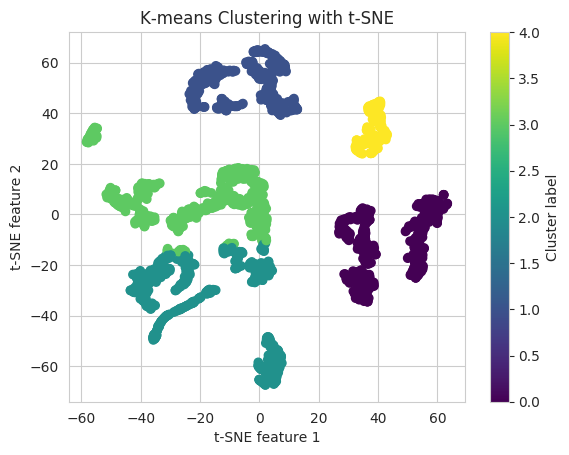

In [8]:
# Visulaization of the observations (position, velocity), cluster of the 5 categories

# Reshape each (10, 2) array into a 20-element vector
X_flattened = X_dataset #np.array([x.flatten() for x in X_dataset])

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_flattened) # if t-SNE is slow; only use a subset

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_reduced)

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Plot the data, colored by cluster assignment
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering with t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Cluster label')
plt.show()

In [9]:
# # split into train, val, and test (70%, 20%, 10%)
# X_train, X_temp, y_train, y_temp = train_test_split(X_dataset, y_dataset, test_size=0.3, random_state=SEED)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=SEED)

# # Printing the shapes of the resulting datasets
# print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
# print(f"Test set: X_test: {X_test.shape}, y_val: {y_test.shape}")

# Considering we have small amount of data, split into train, val=test (85%, 15%)
X_train, X_val, y_train, y_val = train_test_split(X_dataset, y_dataset, test_size=0.15, random_state=SEED)
X_test = X_val
y_test = y_val

# Printing the shapes of the resulting datasets
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_val: {y_test.shape}")

Training set: X_train: (1972, 20), y_train: (1972,)
Validation set: X_val: (348, 20), y_val: (348,)
Test set: X_test: (348, 20), y_val: (348,)


In [10]:
# PT helpers
class TrafficDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TSE_Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TSE_Net, self).__init__() 
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(16, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [11]:
def train(net, train_loader, criterion, optimizer, print_every):
    net.train() 
    running_loss = 0.0
    track_running_loss = []
    for i, bdata in enumerate(train_loader, 0):
        inputs, labels = bdata
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % print_every == print_every - 1:
            running_loss = running_loss / print_every
            track_running_loss.append(running_loss)
            print(f"Training - Batch: {i+1}, Loss: {running_loss:.4f}")
            running_loss = 0.0
            
    return track_running_loss 

def validate(net, val_loader, criterion):
    net.eval()  
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_outputs = net(val_inputs)
            val_batch_loss = criterion(val_outputs, val_labels)
            val_loss += val_batch_loss.item()

            # accuracy
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return val_loss

In [12]:
input_size = X_train.shape[1]  # 20
num_classes = len(np.unique(y))  # 6
net = TSE_Net(input_size, num_classes)

n_epochs = 500
batch_size = 32
print_every = 50

print(f"The model has {count_parameters(net):} trainable parameters")
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(net.parameters(), lr=0.01)

train_data = TrafficDataset(torch.tensor(X_train, dtype=torch.float32), 
                             torch.tensor(y_train.astype(int), dtype=torch.long))

val_data = TrafficDataset(torch.tensor(X_val, dtype=torch.float32), 
                           torch.tensor(y_val.astype(int), dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
train_loss_values = []
epoch_train_loss_values = []
val_loss_values = []

for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}", end = "\t")
    track_running_loss = train(net, train_loader, criterion, optimizer, print_every)
    val_loss = validate(net, val_loader, criterion)
    
    val_loss_values.append(val_loss)
    train_loss_values.extend(track_running_loss)
    epoch_train_loss_values.append(np.mean(track_running_loss))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        
        save_path = './saved_models/'
        os.makedirs(save_path, exist_ok=True)
        torch.save(net.state_dict(), os.path.join(save_path, 'best_tse_model.pt'))
        
        print("###### New model saved ######")

The model has 1285 trainable parameters
Epoch: 1	Training - Batch: 50, Loss: 1.2683
Validation - Loss: 1.0256, Accuracy: 48.28%
###### New model saved ######
Epoch: 2	Training - Batch: 50, Loss: 1.0959
Validation - Loss: 1.0352, Accuracy: 52.30%
Epoch: 3	Training - Batch: 50, Loss: 1.0577
Validation - Loss: 0.9468, Accuracy: 58.62%
###### New model saved ######
Epoch: 4	Training - Batch: 50, Loss: 0.9997
Validation - Loss: 0.8649, Accuracy: 60.63%
###### New model saved ######
Epoch: 5	Training - Batch: 50, Loss: 0.8743
Validation - Loss: 0.6660, Accuracy: 66.67%
###### New model saved ######
Epoch: 6	Training - Batch: 50, Loss: 0.6948
Validation - Loss: 0.6301, Accuracy: 71.26%
###### New model saved ######
Epoch: 7	Training - Batch: 50, Loss: 0.6225
Validation - Loss: 0.4945, Accuracy: 81.32%
###### New model saved ######
Epoch: 8	Training - Batch: 50, Loss: 0.5592
Validation - Loss: 0.5615, Accuracy: 79.31%
Epoch: 9	Training - Batch: 50, Loss: 0.5371
Validation - Loss: 0.4993, Accur

Validation - Loss: 0.3450, Accuracy: 87.36%
Epoch: 90	Training - Batch: 50, Loss: 0.3119
Validation - Loss: 0.2762, Accuracy: 87.64%
Epoch: 91	Training - Batch: 50, Loss: 0.3183
Validation - Loss: 0.3000, Accuracy: 86.78%
Epoch: 92	Training - Batch: 50, Loss: 0.3088
Validation - Loss: 0.3886, Accuracy: 85.34%
Epoch: 93	Training - Batch: 50, Loss: 0.3380
Validation - Loss: 0.3079, Accuracy: 88.22%
Epoch: 94	Training - Batch: 50, Loss: 0.3604
Validation - Loss: 0.3283, Accuracy: 86.49%
Epoch: 95	Training - Batch: 50, Loss: 0.3150
Validation - Loss: 0.3353, Accuracy: 87.36%
Epoch: 96	Training - Batch: 50, Loss: 0.4087
Validation - Loss: 0.3439, Accuracy: 83.91%
Epoch: 97	Training - Batch: 50, Loss: 0.3294
Validation - Loss: 0.3838, Accuracy: 84.48%
Epoch: 98	Training - Batch: 50, Loss: 0.3418
Validation - Loss: 0.3595, Accuracy: 86.49%
Epoch: 99	Training - Batch: 50, Loss: 0.3435
Validation - Loss: 0.2768, Accuracy: 89.66%
Epoch: 100	Training - Batch: 50, Loss: 0.3057
Validation - Loss: 0

Epoch: 182	Training - Batch: 50, Loss: 0.2927
Validation - Loss: 0.2871, Accuracy: 89.66%
Epoch: 183	Training - Batch: 50, Loss: 0.2952
Validation - Loss: 0.2699, Accuracy: 90.52%
Epoch: 184	Training - Batch: 50, Loss: 0.3231
Validation - Loss: 0.2535, Accuracy: 91.09%
Epoch: 185	Training - Batch: 50, Loss: 0.2789
Validation - Loss: 0.3046, Accuracy: 90.23%
Epoch: 186	Training - Batch: 50, Loss: 0.3010
Validation - Loss: 0.2709, Accuracy: 88.51%
Epoch: 187	Training - Batch: 50, Loss: 0.2820
Validation - Loss: 0.2969, Accuracy: 88.79%
Epoch: 188	Training - Batch: 50, Loss: 0.3083
Validation - Loss: 0.3190, Accuracy: 87.64%
Epoch: 189	Training - Batch: 50, Loss: 0.3006
Validation - Loss: 0.2714, Accuracy: 86.78%
Epoch: 190	Training - Batch: 50, Loss: 0.2896
Validation - Loss: 0.3992, Accuracy: 82.47%
Epoch: 191	Training - Batch: 50, Loss: 0.2827
Validation - Loss: 0.2767, Accuracy: 90.80%
Epoch: 192	Training - Batch: 50, Loss: 0.3326
Validation - Loss: 0.2824, Accuracy: 87.64%
Epoch: 193

Validation - Loss: 0.2827, Accuracy: 89.08%
Epoch: 276	Training - Batch: 50, Loss: 0.2932
Validation - Loss: 0.2783, Accuracy: 89.66%
Epoch: 277	Training - Batch: 50, Loss: 0.2760
Validation - Loss: 0.2744, Accuracy: 89.94%
Epoch: 278	Training - Batch: 50, Loss: 0.3141
Validation - Loss: 0.2446, Accuracy: 90.52%
Epoch: 279	Training - Batch: 50, Loss: 0.3092
Validation - Loss: 0.3002, Accuracy: 87.93%
Epoch: 280	Training - Batch: 50, Loss: 0.3047
Validation - Loss: 0.3359, Accuracy: 87.64%
Epoch: 281	Training - Batch: 50, Loss: 0.2789
Validation - Loss: 0.3146, Accuracy: 87.93%
Epoch: 282	Training - Batch: 50, Loss: 0.3112
Validation - Loss: 0.3446, Accuracy: 85.63%
Epoch: 283	Training - Batch: 50, Loss: 0.2917
Validation - Loss: 0.3042, Accuracy: 88.51%
Epoch: 284	Training - Batch: 50, Loss: 0.2953
Validation - Loss: 0.3026, Accuracy: 89.37%
Epoch: 285	Training - Batch: 50, Loss: 0.3224
Validation - Loss: 0.3316, Accuracy: 89.37%
Epoch: 286	Training - Batch: 50, Loss: 0.3015
Validation

Epoch: 372	Training - Batch: 50, Loss: 0.3023
Validation - Loss: 0.3215, Accuracy: 88.51%
Epoch: 373	Training - Batch: 50, Loss: 0.3316
Validation - Loss: 0.3673, Accuracy: 87.36%
Epoch: 374	Training - Batch: 50, Loss: 0.2832
Validation - Loss: 0.3242, Accuracy: 85.63%
Epoch: 375	Training - Batch: 50, Loss: 0.2552
Validation - Loss: 0.2472, Accuracy: 91.09%
Epoch: 376	Training - Batch: 50, Loss: 0.2939
Validation - Loss: 0.2715, Accuracy: 88.79%
Epoch: 377	Training - Batch: 50, Loss: 0.2866
Validation - Loss: 0.3131, Accuracy: 89.08%
Epoch: 378	Training - Batch: 50, Loss: 0.2748
Validation - Loss: 0.2490, Accuracy: 90.80%
Epoch: 379	Training - Batch: 50, Loss: 0.2471
Validation - Loss: 0.3205, Accuracy: 88.51%
Epoch: 380	Training - Batch: 50, Loss: 0.2999
Validation - Loss: 0.3788, Accuracy: 86.49%
Epoch: 381	Training - Batch: 50, Loss: 0.2680
Validation - Loss: 0.3076, Accuracy: 89.08%
Epoch: 382	Training - Batch: 50, Loss: 0.2610
Validation - Loss: 0.3117, Accuracy: 87.93%
Epoch: 383

Epoch: 468	Training - Batch: 50, Loss: 0.2614
Validation - Loss: 0.2928, Accuracy: 90.52%
Epoch: 469	Training - Batch: 50, Loss: 0.2678
Validation - Loss: 0.2574, Accuracy: 91.09%
Epoch: 470	Training - Batch: 50, Loss: 0.2540
Validation - Loss: 0.3278, Accuracy: 87.64%
Epoch: 471	Training - Batch: 50, Loss: 0.2787
Validation - Loss: 0.2810, Accuracy: 90.52%
Epoch: 472	Training - Batch: 50, Loss: 0.2707
Validation - Loss: 0.2765, Accuracy: 90.52%
Epoch: 473	Training - Batch: 50, Loss: 0.3058
Validation - Loss: 0.2957, Accuracy: 90.80%
Epoch: 474	Training - Batch: 50, Loss: 0.2619
Validation - Loss: 0.2578, Accuracy: 90.52%
Epoch: 475	Training - Batch: 50, Loss: 0.3135
Validation - Loss: 0.2919, Accuracy: 91.67%
Epoch: 476	Training - Batch: 50, Loss: 0.2700
Validation - Loss: 0.2546, Accuracy: 87.93%
Epoch: 477	Training - Batch: 50, Loss: 0.2775
Validation - Loss: 0.2909, Accuracy: 90.52%
Epoch: 478	Training - Batch: 50, Loss: 0.2571
Validation - Loss: 0.2780, Accuracy: 89.66%
Epoch: 479

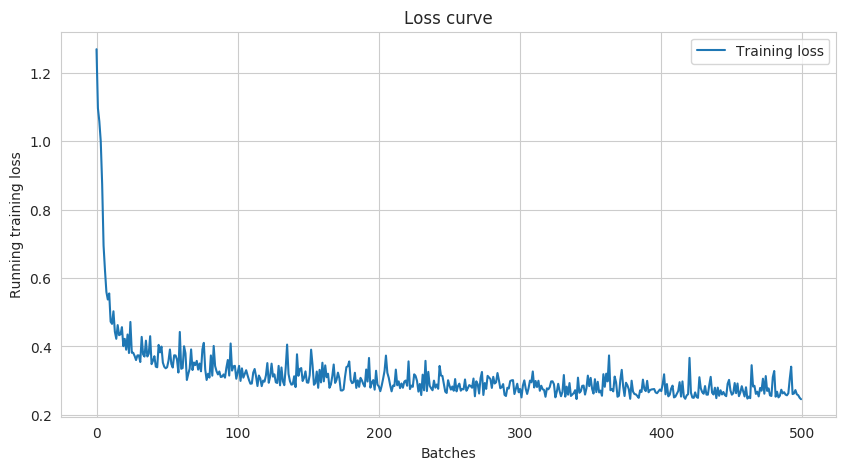

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label = "Training loss")
plt.title('Loss curve')
plt.xlabel('Batches')
plt.ylabel('Running training loss')
plt.legend()

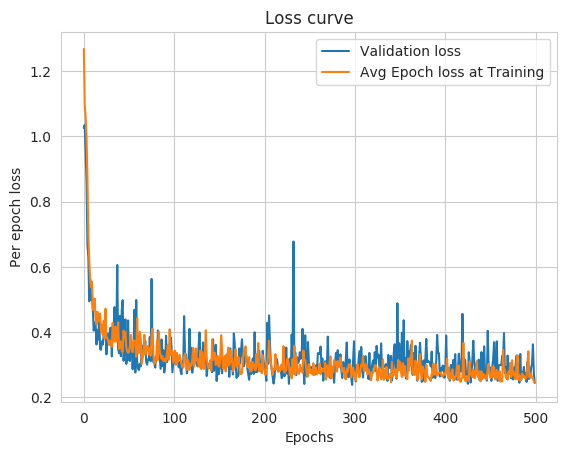

In [14]:
plt.plot(val_loss_values, label="Validation loss")
plt.plot(epoch_train_loss_values, label="Avg Epoch loss at Training")
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Per epoch loss')
plt.legend()

In [15]:
best_model_path = './saved_models/best_tse_model.pt'

input_size = 10*2
num_classes = 5

saved_best_net = TSE_Net(input_size, num_classes)
saved_best_net.load_state_dict(torch.load(best_model_path))
saved_best_net.eval()

# random_input = torch.randn(10, 2).flatten()
# print(random_input)

# with torch.no_grad():
#     outputs = saved_best_net(random_input.unsqueeze(0))

# _, predicted_label = torch.max(outputs, 1)
# predicted_label = predicted_label.numpy()

# print(predicted_label)

TSE_Net(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=5, bias=True)
)

Test accuracy: 90.23%


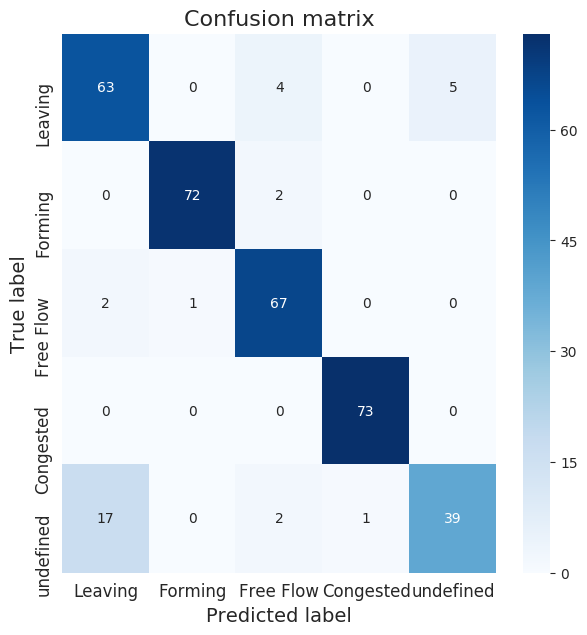

In [16]:
# Analyze: In the validation set what did the best model get wrong?
# Perform this on the test set

label_meanings = ["Leaving", "Forming", "Free Flow", "Congested", "undefined"]

# Get confusion matrix 
y_test_pred = []
with torch.no_grad():
    for x in X_test:
        outputs = saved_best_net(torch.from_numpy(x).unsqueeze(0))
        _, predicted_label = torch.max(outputs, 1)
        y_test_pred.append(predicted_label.numpy()[0])
y_test_pred = np.array(y_test_pred)

# Calculate accuracy on the test set
test_accuracy = np.mean(y_test_pred == y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_test_pred)

fs = 16
fig, ax = plt.subplots(figsize=(7,7), dpi = 100)
ax.tick_params(axis='both', which='major', labelsize=fs-4)
sns.heatmap(cm, annot=True, fmt="d", 
            cmap='Blues', 
            xticklabels=label_meanings, 
            yticklabels=label_meanings)

ax.set_title('Confusion matrix', fontsize=fs)
ax.set_xlabel('Predicted label',fontsize=fs-2)
ax.set_ylabel('True label', fontsize=fs-2)
plt.show()

In [17]:
# To decide how many timesteps into the figure to use
# Look at the error rate (test accuracy) vs timestep number